In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from environment_sar import SARrobotEnv
from agents import QLearningAgentFlat, QLearningAgentMaxInfoRL_ADVANCED

# Configuration
GRID_ROWS = 4
GRID_COLS = 4
INFO_POINTS = 3  # Number of information points to collect
NUM_EPISODES = 5000
LOG_DIR = "./logs/comparison_" + datetime.now().strftime("%Y%m%d_%H%M%S")
POLICY_DIR = os.path.join(LOG_DIR, "policies")

# Create output directories
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(POLICY_DIR, exist_ok=True)

# RL parameters
ALPHA = 0.1
GAMMA = 0.99
EPSILON_MAX = 1.0
DECAY_RATE = 2
EPSILON_MIN = 0.05

# Define experiments
experiments = [
    {
        "name": "Flat_Static",
        "agent_class": QLearningAgentFlat,
        "sparse_reward": False,
        "reward_shaping": False,
        "attention": False,
        "hierarchical": False,
        "change_priorities": None  # No changes
    },
    {
        "name": "Flat_Dynamic",
        "agent_class": QLearningAgentFlat,
        "sparse_reward": False,
        "reward_shaping": False,
        "attention": False,
        "hierarchical": False,
        "change_priorities": {
            2500: {'X': 2, 'Y': 0, 'Z': 1},  # Change from X-Y-Z to Y-Z-X
            #3500: {'X': 1, 'Y': 2, 'Z': 0},   # Change to Z-X-Y

        }
    },
    {
        "name": "MaxInfoRL_Static",
        "agent_class": QLearningAgentMaxInfoRL_ADVANCED,
        "sparse_reward": False,
        "reward_shaping": False,
        "attention": False,
        "hierarchical": False,
        "change_priorities": None  # No changes
    },
    {
        "name": "MaxInfoRL_Dynamic",
        "agent_class": QLearningAgentMaxInfoRL_ADVANCED,
        "sparse_reward": False,
        "reward_shaping": False,
        "attention": False,
        "hierarchical": False,
        "change_priorities": {
            2500: {'X': 2, 'Y': 0, 'Z': 1},  # Change from X-Y-Z to Y-Z-X
            #3500: {'X': 1, 'Y': 2, 'Z': 0},   # Change to Z-X-Y

        }
    }
]

results = {}

# Run experiments
for exp in experiments:
    print(f"\n{'='*80}")
    print(f"Running experiment: {exp['name']}")
    print(f"{'='*80}")
    
    # Create environment
    env = SARrobotEnv(
        grid_rows=GRID_ROWS,
        grid_cols=GRID_COLS,
        info_number_needed=INFO_POINTS,
        sparse_reward=exp["sparse_reward"],
        reward_shaping=exp["reward_shaping"],
        attention=exp["attention"],
        hierarchical=exp["hierarchical"],
        render_mode=None
    )
    
    # Create agent
    agent = exp["agent_class"](
        env=env,
        ALPHA=ALPHA,
        GAMMA=GAMMA,
        EPSILON_MAX=EPSILON_MAX,
        DECAY_RATE=DECAY_RATE,
        EPSILON_MIN=EPSILON_MIN,
        log_rewards_dir=os.path.join(LOG_DIR, exp["name"]),
        learned_policy_dir=os.path.join(POLICY_DIR, exp["name"])
    )
    
    # Train agent
    rewards, steps, metrics = agent.train(NUM_EPISODES, change_priorities_at=exp["change_priorities"])
    
    # Store results
    results[exp["name"]] = {
        "rewards": rewards,
        "steps": steps,
        "metrics": metrics,
        "agent_class": exp["agent_class"].__name__
    }

# Save results
with open(os.path.join(LOG_DIR, 'results.pkl'), 'wb') as f:
    pickle.dump(results, f)

/home/dimi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/dimi/.local/lib/python3.10/site-packages/langchain_community/chat_models/ollama.py:20: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import 


Running experiment: Flat_Static

Environment Configuration:
Sparse Reward Mode: False
Hierarchical Mode: False
Reward Shaping Mode: False
Attention Mechanism: False
Grid Size: 4x4
Required Information Points: 3

[InfoLocation(position=[1, 1], info_type='X', collection_order=0, required=True), InfoLocation(position=[3, 0], info_type='Y', collection_order=1, required=True), InfoLocation(position=[3, 2], info_type='Z', collection_order=2, required=True)]
document json will be infused


2025-04-28 17:38:13.293151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-28 17:38:13.296331: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


  0%|          | 0/5000 [00:00<?, ?it/s]

episode: 0 | reward: 0 | epsilon: 1.0
episode: 500 | reward: -9 | epsilon: 0.800000000000022
episode: 1000 | reward: -20 | epsilon: 0.600000000000044
episode: 1500 | reward: -6 | epsilon: 0.4000000000000522
episode: 2000 | reward: 8 | epsilon: 0.20000000000004647
episode: 2500 | reward: 116 | epsilon: 0.05
episode: 3000 | reward: 115 | epsilon: 0.05
episode: 3500 | reward: 116 | epsilon: 0.05
episode: 4000 | reward: 116 | epsilon: 0.05
episode: 4500 | reward: 116 | epsilon: 0.05

Training Complete!

Exploration and Exploitation Statistics:
Total exploration actions: 18823
Total exploitation actions: 52592
Final exploration/exploitation ratio: 0.26

Information Collection Statistics:

Collection Statistics (Current Episode):
Location (1, 1): 1 attempts, 1 correct (100.0%)
Location (3, 0): 1 attempts, 1 correct (100.0%)
Location (3, 2): 1 attempts, 1 correct (100.0%)

Cumulative Collection Statistics (across Training):
Location (1, 1): 5643 total attempts, 4083 correct (72.4%)
Location (

  0%|          | 0/5000 [00:00<?, ?it/s]

episode: 0 | reward: 0 | epsilon: 1.0
episode: 500 | reward: -13 | epsilon: 0.800000000000022
episode: 1000 | reward: -12 | epsilon: 0.600000000000044
episode: 1500 | reward: -4 | epsilon: 0.4000000000000522
episode: 2000 | reward: 115 | epsilon: 0.20000000000004647

Collection priorities changed at episode 2500
New collection order: {'X': 2, 'Y': 0, 'Z': 1}
Priority change detected: Boosting Epsilon to 0.1000 for 50 episodes.
episode: 2500 | reward: 116 | epsilon: 0.1

Episode 2549: Epsilon boost ended. Restoring Epsilon from 0.1000 towards 0.0500.
episode: 3000 | reward: -20 | epsilon: 0.05
episode: 3500 | reward: -47 | epsilon: 0.05
episode: 4000 | reward: -41 | epsilon: 0.05
episode: 4500 | reward: -18 | epsilon: 0.05

Training Complete!

Exploration and Exploitation Statistics:
Total exploration actions: 18076
Total exploitation actions: 52150
Final exploration/exploitation ratio: 0.26

Information Collection Statistics:

Collection Statistics (Current Episode):
Location (3, 0): 1

  0%|          | 0/5000 [00:00<?, ?it/s]

episode: 0 | reward: 0 | epsilon: 1.0
episode: 500 | reward: -45 | epsilon: 0.800000000000022
episode: 1000 | reward: 1 | epsilon: 0.600000000000044
episode: 1500 | reward: -5 | epsilon: 0.4000000000000522
episode: 2000 | reward: 112 | epsilon: 0.20000000000004647
episode: 2500 | reward: 114 | epsilon: 0.05
episode: 3000 | reward: 114 | epsilon: 0.05
episode: 3500 | reward: 114 | epsilon: 0.05
episode: 4000 | reward: 114 | epsilon: 0.05
episode: 4500 | reward: 114 | epsilon: 0.05

Training Complete!

Exploration and Exploitation Statistics:
Total exploration actions: 49005
Total exploitation actions: 68873
Final exploration/exploitation ratio: 0.42

Information Collection Statistics:

Collection Statistics (Current Episode):
Location (1, 1): 1 attempts, 1 correct (100.0%)
Location (3, 0): 1 attempts, 1 correct (100.0%)
Location (3, 2): 1 attempts, 1 correct (100.0%)

Cumulative Collection Statistics (across Training):
Location (1, 1): 4845 total attempts, 4845 correct (100.0%)
Location

  0%|          | 0/5000 [00:00<?, ?it/s]

episode: 0 | reward: 0 | epsilon: 1.0
episode: 500 | reward: -45 | epsilon: 0.800000000000022
episode: 1000 | reward: -35 | epsilon: 0.600000000000044
episode: 1500 | reward: -14 | epsilon: 0.4000000000000522
episode: 2000 | reward: 116 | epsilon: 0.20000000000004647

Collection priorities changed at episode 2500
New collection order: {'X': 2, 'Y': 0, 'Z': 1}
Priority change detected: Boosting Epsilon to 0.1000 for 50 episodes.
episode: 2500 | reward: 115 | epsilon: 0.1

Episode 2549: Epsilon boost ended. Restoring Epsilon from 0.1000 towards 0.0500.
episode: 3000 | reward: -13 | epsilon: 0.05
episode: 3500 | reward: 115 | epsilon: 0.05
episode: 4000 | reward: 112 | epsilon: 0.05
episode: 4500 | reward: 114 | epsilon: 0.05

Training Complete!

Exploration and Exploitation Statistics:
Total exploration actions: 50321
Total exploitation actions: 73032
Final exploration/exploitation ratio: 0.41

Information Collection Statistics:

Collection Statistics (Current Episode):
Location (3, 0): 

In [ ]:
agent


PERFORMANCE COMPARISON SUMMARY
Metric                                   | Flat_Static     | Flat_Dynamic    | MaxInfoRL_Static | MaxInfoRL_Dynamic
Mission Success (%)                      | 57.34           | 9.24            | 67.58           | 48.22          
Info Collection (%)                      | 62.52           | 16.28           | 76.22           | 56.18          
Success Without Collisions (%)           | 0.00            | 0.00            | 0.52            | 0.16           
Avg Steps                                | 14.28           | 14.05           | 23.58           | 24.67          
average_reward_per_episode               | 59.46           | -1.97           | 66.79           | 42.88          
exploration_exploitation_ratio           | 0.26            | 0.26            | 0.42            | 0.41           

Experiment complete! Results saved to: ./logs/comparison_20250428_173812


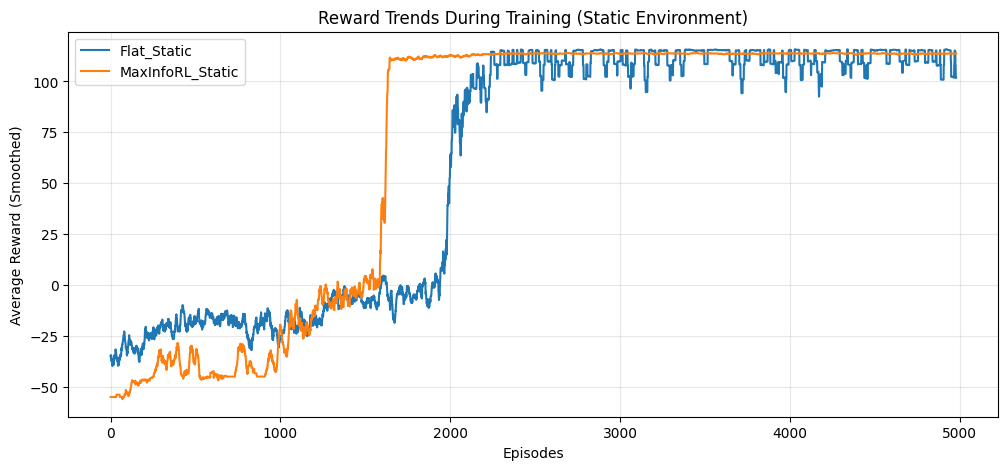

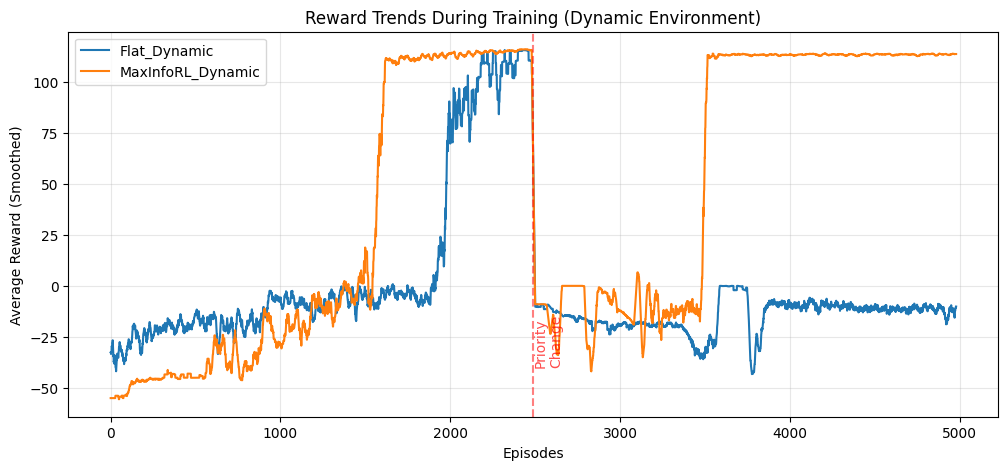

<Figure size 1000x800 with 0 Axes>

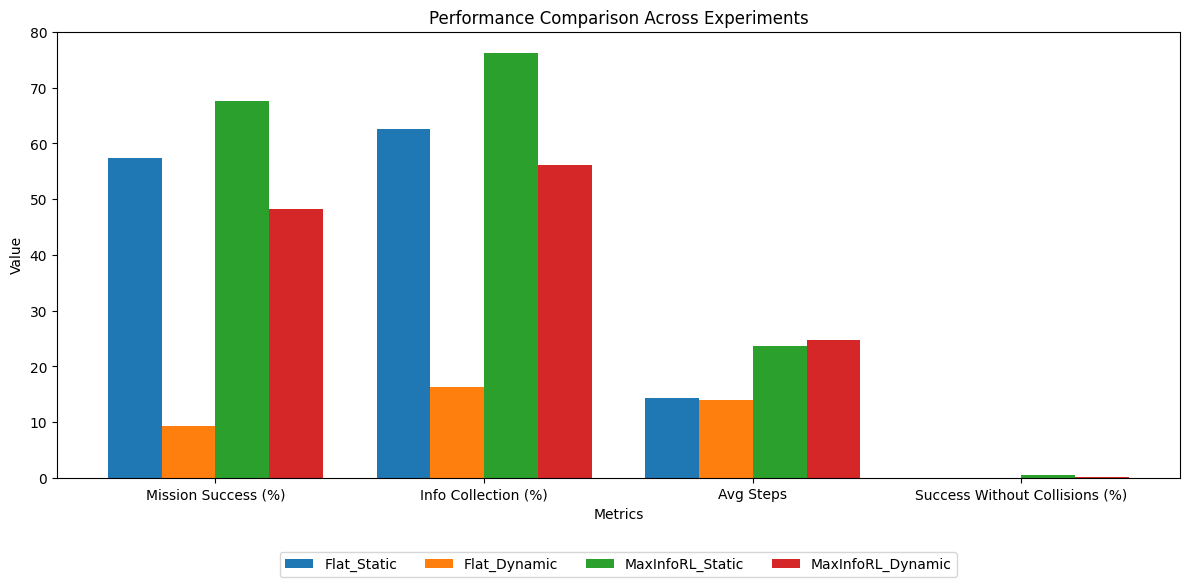

In [2]:
# Create comparison visualizations
# 1. Reward trends - Separate plots for static and dynamic
window_size = 20  # For smoothing

# Static environment plot
plt.figure(figsize=(12, 5))
for exp_name, data in results.items():
    if "Static" in exp_name:  # Only include static experiments
        rewards = data["rewards"]
        # Smooth rewards using moving average
        smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_rewards, label=exp_name)

plt.title('Reward Trends During Training (Static Environment)')
plt.xlabel('Episodes')
plt.ylabel('Average Reward (Smoothed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(LOG_DIR, 'reward_trends_static.png'))

# Dynamic environment plot
plt.figure(figsize=(12, 5))
dynamic_smoothed_rewards = {}  # Store for min/max calculation

for exp_name, data in results.items():
    if "Dynamic" in exp_name:  # Only include dynamic experiments
        rewards = data["rewards"]
        # Smooth rewards using moving average
        smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_rewards, label=exp_name)
        dynamic_smoothed_rewards[exp_name] = smoothed_rewards

# Add priority change markers (if we have data for dynamic experiments)
if dynamic_smoothed_rewards:
    # Calculate global min/max for consistent text placement
    all_rewards = np.concatenate(list(dynamic_smoothed_rewards.values()))
    min_reward = np.min(all_rewards)
    max_reward = np.max(all_rewards)
    
    # Get the change priority episodes from one of the dynamic experiments
    for exp in experiments:
        if exp["change_priorities"] is not None:
            for episode in exp["change_priorities"].keys():
                if episode >= window_size//2:
                    adjusted_episode = episode - window_size//2
                    plt.axvline(x=adjusted_episode, color='r', linestyle='--', alpha=0.5)
                    plt.text(adjusted_episode, min_reward + (max_reward-min_reward)*0.1, 
                            f"Priority\nChange", rotation=90, color='r', alpha=0.7)
            break  # Only need one experiment's change points as they're the same

plt.title('Reward Trends During Training (Dynamic Environment)')
plt.xlabel('Episodes')
plt.ylabel('Average Reward (Smoothed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(LOG_DIR, 'reward_trends_dynamic.png'))

# 2. Adaptation metrics comparison (for dynamic experiments)
plt.figure(figsize=(10, 8))

# Extract adaptation metrics
flat_changes = []
maxinfo_changes = []

for exp_name, data in results.items():
    if "Dynamic" in exp_name and "priority_changes" in data["metrics"]:
        changes = data["metrics"]["priority_changes"]
        if "Flat" in exp_name:
            flat_changes = changes
        else:
            maxinfo_changes = changes

# Compare adaptation metrics side by side
if flat_changes and maxinfo_changes:
    # Setup plot for adaptation time
    plt.subplot(2, 1, 1)
    labels = [f"Change {i+1}" for i in range(min(len(flat_changes), len(maxinfo_changes)))]
    x = np.arange(len(labels))
    width = 0.35
    
    # Extract steps to adapt
    flat_steps = [change.get('steps_to_adapt', 0) for change in flat_changes[:len(labels)]]
    maxinfo_steps = [change.get('steps_to_adapt', 0) for change in maxinfo_changes[:len(labels)]]
    
    plt.bar(x - width/2, flat_steps, width, label='Flat Agent')
    plt.bar(x + width/2, maxinfo_steps, width, label='MaxInfoRL Agent')
    plt.ylabel('Steps to Adapt')
    plt.title('Adaptation Time After Priority Changes')
    plt.xticks(x, labels)
    plt.legend()
    
    # Setup plot for success rate improvement
    plt.subplot(2, 1, 2)
    
    # Calculate success rate improvement (after - before)
    flat_improvements = [change.get('success_rate_after', 0) - change.get('success_rate_before', 0) 
                        for change in flat_changes[:len(labels)]]
    maxinfo_improvements = [change.get('success_rate_after', 0) - change.get('success_rate_before', 0) 
                           for change in maxinfo_changes[:len(labels)]]
    
    plt.bar(x - width/2, flat_improvements, width, label='Flat Agent')
    plt.bar(x + width/2, maxinfo_improvements, width, label='MaxInfoRL Agent')
    plt.ylabel('Success Rate Improvement (%)')
    plt.title('Performance Improvement After Adaptation')
    plt.xticks(x, labels)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(LOG_DIR, 'adaptation_metrics.png'))

# 3. Overall performance comparison
plt.figure(figsize=(12, 6))

# Key metrics to compare
metrics_to_compare = [
    'mission_success_rate', 
    'info_collection_success_rate',
    'average_steps_per_episode',
    'mission_success_no_collisions_rate'
]

metric_labels = {
    'mission_success_rate': 'Mission Success (%)',
    'info_collection_success_rate': 'Info Collection (%)',
    'average_steps_per_episode': 'Avg Steps',
    'mission_success_no_collisions_rate': 'Success Without Collisions (%)'
}

# Setup bar chart
x = np.arange(len(metrics_to_compare))
width = 0.2
exp_names = list(results.keys())

for i, exp_name in enumerate(exp_names):
    values = [results[exp_name]['metrics'].get(metric, 0) for metric in metrics_to_compare]
    offset = width * (i - len(exp_names)/2 + 0.5)
    plt.bar(x + offset, values, width, label=exp_name)

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Performance Comparison Across Experiments')
plt.xticks(x, [metric_labels[metric] for metric in metrics_to_compare])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(exp_names))
plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, 'performance_comparison.png'))

# Print summary table
print("\n" + "="*100)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*100)
print(f"{'Metric':<40} | {'Flat_Static':<15} | {'Flat_Dynamic':<15} | {'MaxInfoRL_Static':<15} | {'MaxInfoRL_Dynamic':<15}")
print("="*100)

metrics_to_print = [
    'mission_success_rate',
    'info_collection_success_rate', 
    'mission_success_no_collisions_rate',
    'average_steps_per_episode',
    'average_reward_per_episode',
    'exploration_exploitation_ratio'
]

for metric in metrics_to_print:
    values = []
    for exp_name in ["Flat_Static", "Flat_Dynamic", "MaxInfoRL_Static", "MaxInfoRL_Dynamic"]:
        if exp_name in results:
            value = results[exp_name]["metrics"].get(metric, "N/A")
            if isinstance(value, (int, float)):
                values.append(f"{value:.2f}")
            else:
                values.append(str(value))
        else:
            values.append("N/A")
    
    metric_name = metric_labels.get(metric, metric)
    print(f"{metric_name:<40} | {values[0]:<15} | {values[1]:<15} | {values[2]:<15} | {values[3]:<15}")

# Print adaptation summary for dynamic experiments
if flat_changes and maxinfo_changes:
    print("\n" + "="*100)
    print("ADAPTATION METRICS SUMMARY")
    print("="*100)
    print(f"{'Metric':<30} | {'Flat_Dynamic':<15} | {'MaxInfoRL_Dynamic':<15} | {'Improvement':<15}")
    print("="*100)
    
    # Average steps to adapt
    flat_avg_steps = np.mean([change.get('steps_to_adapt', 0) for change in flat_changes if change.get('adaptation_completed', False)])
    maxinfo_avg_steps = np.mean([change.get('steps_to_adapt', 0) for change in maxinfo_changes if change.get('adaptation_completed', False)])
    step_diff = maxinfo_avg_steps - flat_avg_steps
    step_pct = (flat_avg_steps - maxinfo_avg_steps) / flat_avg_steps * 100 if flat_avg_steps > 0 else 0
    step_sign = "+" if step_pct > 0 else ""
    
    print(f"{'Avg Steps to Adapt':<30} | {flat_avg_steps:.1f}:<15 | {maxinfo_avg_steps:.1f}:<15 | {step_sign}{step_pct:.1f}%")
    
    # Average success rate improvement
    flat_avg_improve = np.mean([change.get('success_rate_after', 0) - change.get('success_rate_before', 0) 
                               for change in flat_changes if change.get('adaptation_completed', False)])
    maxinfo_avg_improve = np.mean([change.get('success_rate_after', 0) - change.get('success_rate_before', 0) 
                                  for change in maxinfo_changes if change.get('adaptation_completed', False)])
    improve_diff = maxinfo_avg_improve - flat_avg_improve
    improve_sign = "+" if improve_diff > 0 else ""
    
    print(f"{'Avg Success Rate Improvement':<30} | {flat_avg_improve:.1f}%:<15 | {maxinfo_avg_improve:.1f}%:<15 | {improve_sign}{improve_diff:.1f}%")

print("\nExperiment complete! Results saved to:", LOG_DIR)

In [4]:
from evaluation import evaluate_trained_policy
evaluate_trained_policy(agent, "logs/comparison_20250428_173812/policies/MaxInfoRL_Dynamic/q_extrinsic_table_episode_5000.npy")
# evaluate_trained_policy(agent_maxinfo, "policies/ADV/q_extrinsic_table_episode_5000.npy")


Loading Q-table from: logs/comparison_20250428_173812/policies/MaxInfoRL_Dynamic/q_extrinsic_table_episode_5000.npy
Step 1: || State=(2, 1, 0, 0) || Action=DOWN || Reward=-1 || Next State=(3, 1, 0, 0) || Done=False
Step 2: || State=(3, 1, 0, 0) || Action=LEFT || Reward=-1 || Next State=(3, 0, 0, 0) || Done=False
Step 3: || State=(3, 0, 0, 0) || Action=COLLECT_Y || Reward=9 || Next State=(3, 0, 1, 0) || Done=False
Step 4: || State=(3, 0, 1, 0) || Action=RIGHT || Reward=-1 || Next State=(3, 1, 1, 0) || Done=False
Step 5: || State=(3, 1, 1, 0) || Action=RIGHT || Reward=-1 || Next State=(3, 2, 1, 0) || Done=False
Step 6: || State=(3, 2, 1, 0) || Action=COLLECT_Z || Reward=9 || Next State=(3, 2, 2, 0) || Done=False
Step 7: || State=(3, 2, 2, 0) || Action=LEFT || Reward=-1 || Next State=(3, 1, 2, 0) || Done=False
Step 8: || State=(3, 1, 2, 0) || Action=UP || Reward=-1 || Next State=(2, 1, 2, 0) || Done=False
Step 9: || State=(2, 1, 2, 0) || Action=UP || Reward=-1 || Next State=(1, 1, 2, 0) 

(114.0, 100.0)

In [ ]:
### FOR TESTING ### newwww

In [ ]:
## 1) Q-learning-flat -- TESTING
env = SARrobotEnv(
            grid_rows=4,
            grid_cols=4,
            info_number_needed=3,
            sparse_reward=False,
            reward_shaping=False,
            attention=False,
            hierarchical=False,
            render_mode='None'
        )
all_total_rewards_AGENT_flat = []  # List to store total rewards from each run
all_total_steps_AGENT_flat = []  # List to store total rewards from each run
all_metrics_AGENT_flat = [] # New list to store metrics from each run

for _ in range(param.testing_runs):
    EPISODES = param.EPISODES
    ALPHA = param.ALPHA
    GAMMA = param.GAMMA
    EPSILON_MAX = param.EPSILON_MAX
    EPSILON_MIN = 0.1
    DECAY_RATE = param.DECAY_RATE
    agent_flat = QLearningAgentFlat(env, ALPHA, GAMMA, EPSILON_MAX, DECAY_RATE, EPSILON_MIN,
                                    log_rewards_dir="curves/flat", learned_policy_dir="policies/flat")
    rewards_flat, steps_flat, metrics_flat = agent_flat.train(5000)

    all_total_rewards_AGENT_flat.append(rewards_flat)
    all_total_steps_AGENT_flat.append(steps_flat)
    all_metrics_AGENT_flat.append(metrics_flat)  # Store the metrics
# save_training_results(agent_config['labels'][0], all_total_rewards_AGENT_flat, all_total_steps_AGENT_flat, all_metrics_AGENT_flat, save_dir='saved_results_no_sparse')
# time.sleep(param.sleeping_time)

In [ ]:
env = SARrobotEnv(
            grid_rows=4,
            grid_cols=4,
            info_number_needed=3,
            sparse_reward=False,
            reward_shaping=False,
            attention=False,
            hierarchical=False,
            render_mode='None'
        )
all_total_rewards_AGENTmaxinfo = []  # List to store total rewards from each run
all_total_steps_AGENTmaxinfo = []  # List to store total rewards from each run
all_metrics_AGENTmaxinfo = [] # New list to store metrics from each run

for _ in range(param.testing_runs):
    EPISODES = param.EPISODES
    ALPHA = param.ALPHA
    GAMMA = param.GAMMA
    EPSILON_MAX = param.EPSILON_MAX
    EPSILON_MIN = 0.1
    DECAY_RATE = param.DECAY_RATE
    agent_maxinfo = QLearningAgentMaxInfoRL_ADVANCED(env, ALPHA, GAMMA, EPSILON_MAX, DECAY_RATE, EPSILON_MIN,
                                    log_rewards_dir="curves/ADV", learned_policy_dir="policies/ADV")
    rewards_maxinfo, steps_maxinfo, metrics_maxinfo = agent_maxinfo.train(5000)

    all_total_rewards_AGENTmaxinfo.append(rewards_maxinfo)
    all_total_steps_AGENTmaxinfo.append(steps_maxinfo)
    all_metrics_AGENTmaxinfo.append(metrics_maxinfo)  # Store the metrics